# Scaling Python with Azure ML and Dask

![Describe gif](media/describe6.gif)

## Environment setup

This notebook assumes you are using an Azure ML Compute Instance with the default kernel `azureml_py36`. This contains many unneccesary packages. If you want to avoid a long image build time, you may want to create a new conda environment with the minimal packages needed for your scenario. 

It is important that the local environment matches the remote environment to avoid mismatch issues when submitting commands to the remote cluster. To help with this, we will use Azure ML Environments. 

In [ ]:
pip install --upgrade dask[complete] adlfs lz4 distributed fastparquet pyarrow azureml-sdk[notebooks] azureml-dataprep[fuse]

In [ ]:
pip uninstall azureml-samples -y

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML('<script>Jupyter.notebook.kernel.restart()</script>')

In [ ]:
import os

os.system('sudo cp /etc/nginx/nginx.conf setup/temp.conf') # stupid

nginx = ''

with open('setup/temp.conf') as f:
    for line in f.readlines():
        if 'websocket/|/ws/' in line:
            nginx += line.replace('websocket/|/ws/', 'websocket/|/ws')
        else:
            nginx += line
       
with open('setup/temp2.conf', 'w') as f:
    f.write(nginx)
    
os.system('sudo mv setup/temp2.conf /etc/nginx/nginx.conf')
os.system('sudo service nginx restart')
os.system('rm setup/temp.conf');

## Imports

Import all packages used in this notebook.

In [1]:
import os
import sys
import dask
import glob
import socket
import matplotlib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from IPython.core.display import HTML

from azureml.widgets import RunDetails
from azureml.train.estimator import Estimator
from azureml.core.runconfig import MpiConfiguration
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.core import Workspace, Experiment, Dataset, Environment

%matplotlib inline 

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception cannot import name '_DistributedTraining'.


## Azure ML Setup

Get the workspace.

In [2]:
ws = Workspace.from_config()
ws

Workspace.create(name='ncus-azuremlol2', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')

In [3]:
STORAGE_OPTIONS={'account_name': name, 'account_key': key}

### Create environment 

Create the environment to be used on the remote cluster. 

In [4]:
env_name = 'dask'

if env_name not in ws.environments:
    env = Environment.from_existing_conda_environment(env_name, 'azureml_py36')
    env.python.conda_dependencies.add_pip_package('mpi4py') # needed for remote cluster
    env = env.register(ws)
else:
    env = ws.environments[env_name]
    
env.name, env.version

('dask', '1')

### Create dataset

Create the dataset to be used. 

In [5]:
dataset_name = 'noaa-isd-files'
data_paths   = ['https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/year=*/month=*/*.parquet']
local_path   = '/mnt/data/noaa/isd'
remote_path  = '/datasets/noaa/isd'

if dataset_name not in ws.datasets:
    ds = Dataset.File.from_files(data_paths, validate=False)
    # begin stupid 
    os.system('sudo chmod 777 /mnt') # stupid 
    ds.download(local_path)
    ws.get_default_datastore().upload(local_path, remote_path)
    ds = Dataset.File.from_files((ws.get_default_datastore(), remote_path))
    # end stupid
    ds = ds.register(ws, dataset_name)
else:
    ds = ws.datasets[dataset_name]
    
ds

{
  "source": [
    "('workspaceblobstore', 'datasets/noaa/isd')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "2b646979-d2b9-4d1e-8b5d-9b1f9397bb7f",
    "name": "noaa-isd-files",
    "version": 1,
    "workspace": "Workspace.create(name='ncus-azuremlol2', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')"
  }
}

### Create VM pool

Create Azure ML VM pool for creating remote dask cluster(s).

In [6]:
pool_name = 'manyraspberrypis'

if pool_name not in ws.compute_targets:
    # create config for Azure ML cluster
    # change properties as needed
    config = AmlCompute.provisioning_configuration(
             vm_size                 = 'STANDARD_DS13_V2',
             max_nodes               = 100,
             vnet_resourcegroup_name = ws.resource_group,
             vnet_name               = 'dask-vnet',
             subnet_name             = 'default'
    )
    
    ct = ComputeTarget.create(ws, pool_name, config)
    ct.wait_for_completion(show_output=True)    
else:
    ct = ws.compute_targets[pool_name]
    
ct

AmlCompute(workspace=Workspace.create(name='ncus-azuremlol2', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg'), name=manyraspberrypis, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/copetersrg/providers/Microsoft.MachineLearningServices/workspaces/ncus-azuremlol2/computes/manyraspberrypis, type=AmlCompute, provisioning_state=Succeeded, location=northcentralus, tags=None)

## Startup cluster

In [7]:
exp_name   = 'dask2020'

script_params = {
    '--datastore': ws.get_default_datastore(),
    #'--script'   : 'run.py' # run code in run.py on cluster and teardown (batch processing)
}

est = Estimator('setup', 
                compute_target          = ct, 
                entry_script            = 'start.py', 
                environment_definition  = env, 
                script_params           = script_params,
                node_count              = 20,
                distributed_training    = MpiConfiguration()
               )

#run = next(ws.experiments[exp_name].get_runs()) # use this to get existing run (if kernel restarted, etc)
run = Experiment(ws, exp_name).submit(est)
run

WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.


Experiment,Id,Type,Status,Details Page,Docs Page
dask2020,dask2020_1578182001_6cbfa595,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


## Dataset overview

This uses an [Azure Open Dataset](https://azure.microsoft.com/services/open-datasets/catalog/) of [NOAA Integrated Surface Data (ISD)](https://azure.microsoft.com/services/open-datasets/catalog/noaa-integrated-surface-data/) containing worldwide hourly weather data such as temperature, precipitation, and wind. 

Expanded in memory, the full dataset is ~660 GB. It is stored in compressed parquet files in a blob container partitioned by year and month. The dataset is updated daily. Compressed, the files for the dataset are ~8 GB. Uncompressed, the files for the dataset are ~150-200 GB.  

Specific years and months can be specified by `year=*/month=*/part-*.snappy.parquet`. 

The data begins in 2008 and contains 1 file per month. Each file can contain ~5 GB of data when in a dataframe in memory.

In [8]:
%time files = glob.glob(f'{local_path}/year=*/month=*/*.parquet', recursive=True)
files[-5:]

CPU times: user 4.67 ms, sys: 141 µs, total: 4.81 ms
Wall time: 4.12 ms


['/mnt/data/noaa/isd/year=2019/month=10/part-00122-tid-2687234633871530472-ca77b175-44d8-46a7-bcdf-edc88166182a-55767-1.c000.snappy.parquet',
 '/mnt/data/noaa/isd/year=2019/month=8/part-00103-tid-2687234633871530472-ca77b175-44d8-46a7-bcdf-edc88166182a-55528-1.c000.snappy.parquet',
 '/mnt/data/noaa/isd/year=2019/month=4/part-00102-tid-2687234633871530472-ca77b175-44d8-46a7-bcdf-edc88166182a-55544-1.c000.snappy.parquet',
 '/mnt/data/noaa/isd/year=2019/month=2/part-00174-tid-2687234633871530472-ca77b175-44d8-46a7-bcdf-edc88166182a-55556-1.c000.snappy.parquet',
 '/mnt/data/noaa/isd/year=2019/month=5/part-00066-tid-2687234633871530472-ca77b175-44d8-46a7-bcdf-edc88166182a-55555-1.c000.snappy.parquet']

## Pandas

In [9]:
files = glob.glob(f'{local_path}/year=2019/month=12/*.parquet', recursive=True) # 1 month of data
files[-5:]

['/mnt/data/noaa/isd/year=2019/month=12/part-00024-tid-2687234633871530472-ca77b175-44d8-46a7-bcdf-edc88166182a-55553-1.c000.snappy.parquet']

In [10]:
df = pd.read_parquet(files[0])
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,062700,99999,2019-12-01 00:00:00,53.217,5.767,2.0,190.0,1.0,-0.3,1023.4,...,NaN,6.0,0.0,NaN,LEEUWARDEN,NL,062700-99999,2019,1,1.0
1,062700,99999,2019-12-01 00:05:00,53.229,5.761,1.0,200.0,1.5,0.0,NaN,...,NaN,NaN,NaN,NaN,LEEUWARDEN,NL,062700-99999,2019,1,1.0
2,062700,99999,2019-12-01 00:21:00,53.229,5.761,1.0,NaN,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,LEEUWARDEN,NL,062700-99999,2019,1,1.0
3,062700,99999,2019-12-01 00:25:00,53.229,5.761,1.0,180.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,LEEUWARDEN,NL,062700-99999,2019,1,1.0
4,062700,99999,2019-12-01 00:39:00,53.229,5.761,1.0,NaN,1.0,-1.0,NaN,...,NaN,NaN,NaN,NaN,LEEUWARDEN,NL,062700-99999,2019,1,1.0


In [11]:
%time len(df)

CPU times: user 20 µs, sys: 5 µs, total: 25 µs
Wall time: 29.1 µs


9984756

In [12]:
%time df.describe()

CPU times: user 5.37 s, sys: 1.44 s, total: 6.8 s
Wall time: 6.8 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,9.984756e+06,9.984756e+06,9.984756e+06,9.336219e+06,9.580611e+06,9.757185e+06,4.580659e+06,1.513828e+06,517849.000000,2.689519e+06,2.689519e+06,144831.000000,9984756.0,9.984756e+06,9984756.0
mean,3.563902e+01,-2.726802e+01,3.590068e+02,1.671637e+02,3.551021e+00,5.733371e+00,1.014027e+03,3.744878e+01,3.789850,1.503504e+01,2.259137e+03,10.996396,2019.0,1.599844e+01,1.0
std,2.454915e+01,7.889415e+01,7.001707e+02,1.137600e+02,3.078978e+00,1.259994e+01,1.174272e+01,3.010056e+01,3.035806,2.901579e+01,4.173188e+03,18.805107,0.0,8.953685e+00,0.0
min,-9.000000e+01,-1.799830e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-8.400000e+01,8.614000e+02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,2019.0,1.000000e+00,1.0
25%,3.236700e+01,-9.198100e+01,3.300000e+01,6.000000e+01,1.500000e+00,-1.200000e+00,1.008400e+03,1.000000e+01,1.000000,1.000000e+00,0.000000e+00,1.000000,2019.0,8.000000e+00,1.0
50%,4.153300e+01,-5.401300e+01,1.600000e+02,1.700000e+02,3.000000e+00,5.000000e+00,1.014800e+03,4.400000e+01,4.000000,1.000000e+00,0.000000e+00,1.000000,2019.0,1.600000e+01,1.0
75%,4.894100e+01,2.058300e+01,3.970000e+02,2.600000e+02,5.000000e+00,1.300000e+01,1.021600e+03,6.500000e+01,7.000000,1.200000e+01,6.100000e+01,15.000000,2019.0,2.400000e+01,1.0
max,8.365000e+01,1.797500e+02,9.999000e+03,3.600000e+02,8.800000e+01,6.000000e+01,1.088500e+03,9.900000e+01,9.000000,9.900000e+01,9.999000e+03,390.000000,2019.0,3.100000e+01,1.0


In [13]:
%time bites = df.memory_usage(index=True, deep=True).sum()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 4.03 s, sys: 36.7 ms, total: 4.07 s
Wall time: 4.06 s
Dataframe is: 4.8GB


In [14]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean()
means.head()

CPU times: user 651 ms, sys: 406 ms, total: 1.06 s
Wall time: 1.06 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2019-12-01,35.704098,-28.676539,360.953552,175.334623,3.984172,5.857012,1013.546711,46.324600,4.049514,14.998314,2112.794323,9.358607,2019,1,1.0
2019-12-02,35.524892,-26.631679,355.061030,193.481755,3.729187,5.131950,1013.759784,41.708790,4.231676,15.830040,2344.422002,10.376693,2019,2,1.0
2019-12-03,35.485208,-26.305099,356.886431,183.229631,3.412932,5.284834,1013.719291,36.476575,3.939467,16.796437,2508.400531,10.457428,2019,3,1.0
2019-12-04,35.682193,-26.356791,359.951759,179.814224,3.344442,5.905213,1012.489592,35.312662,3.690052,16.906751,2564.446335,8.732609,2019,4,1.0
2019-12-05,35.765339,-26.843494,365.376117,170.223265,3.381195,5.905333,1013.816402,34.095361,3.421218,15.723318,2459.378260,9.979785,2019,5,1.0


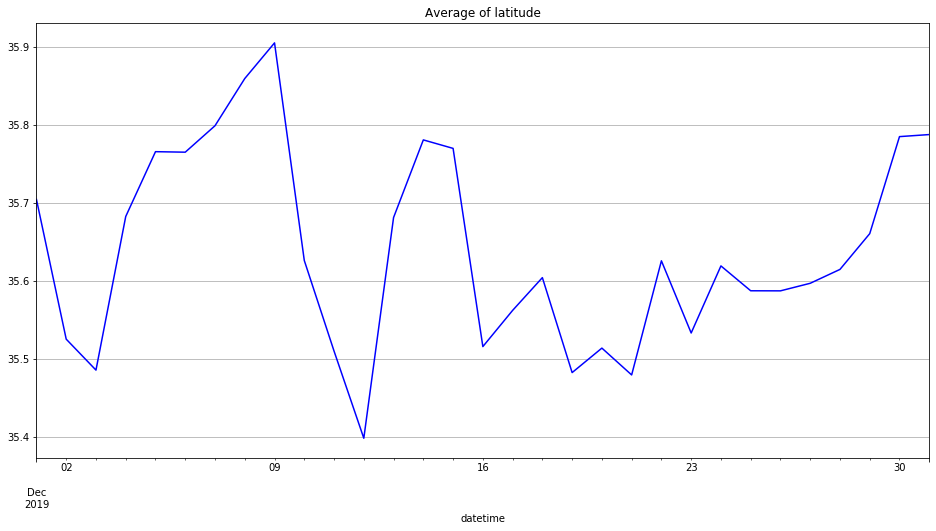

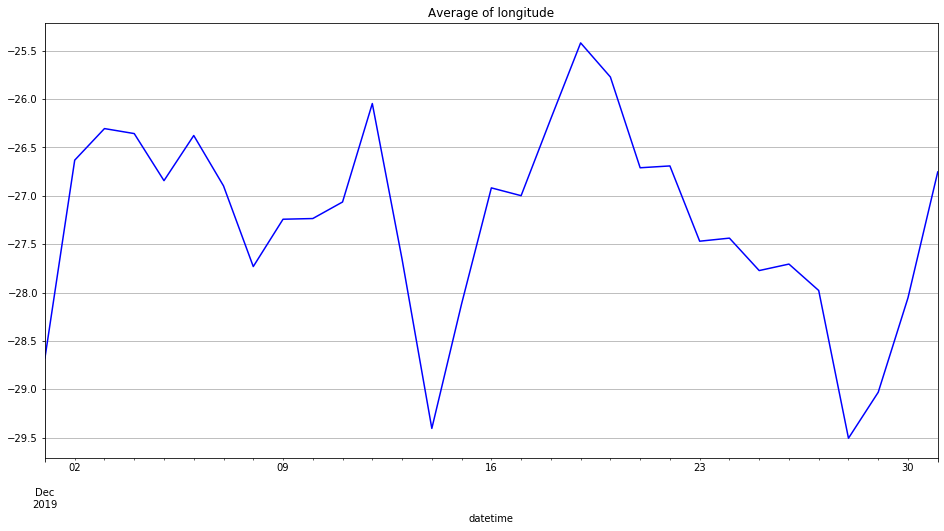

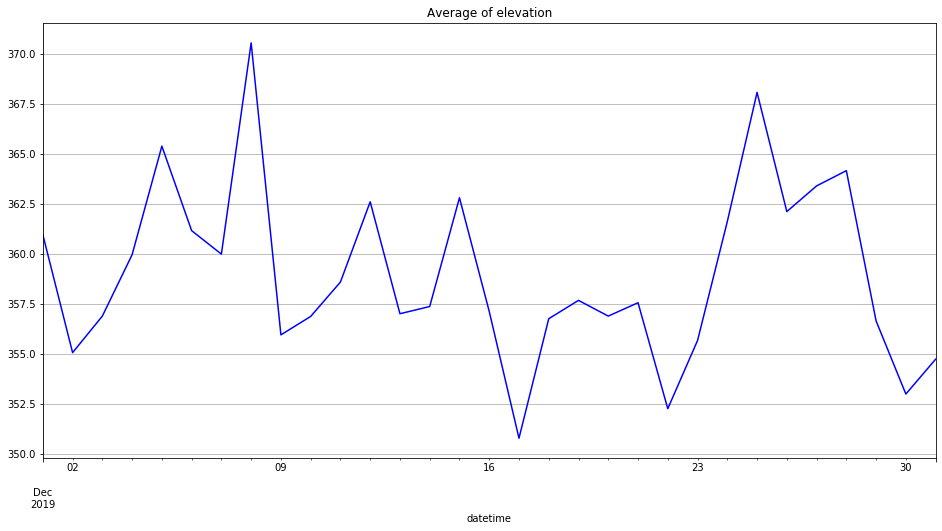

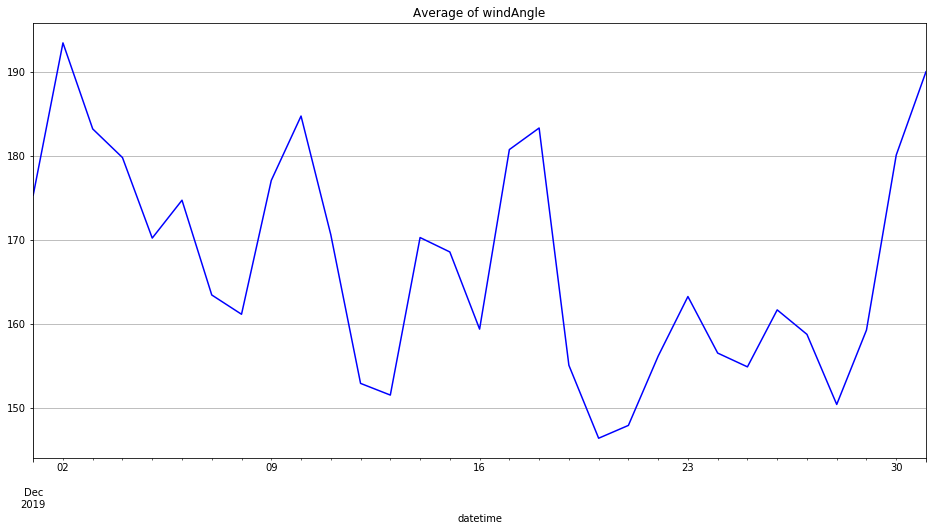

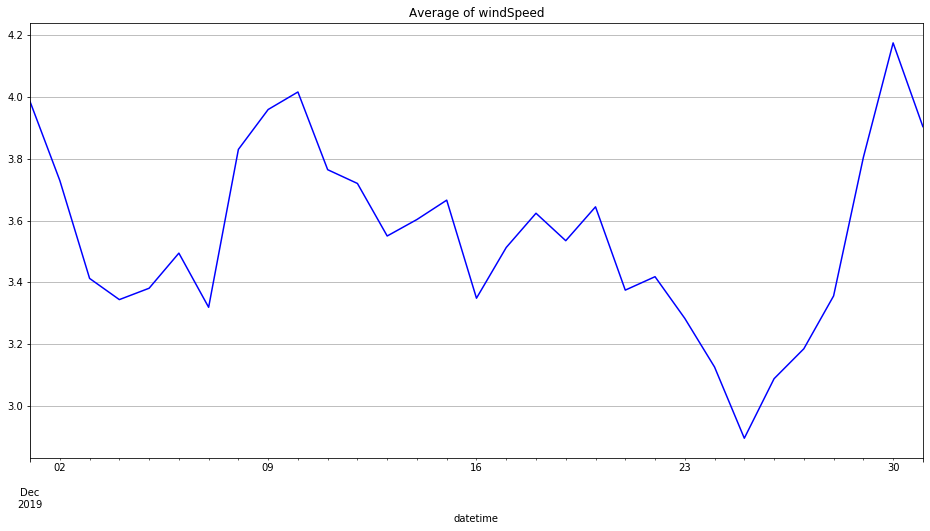

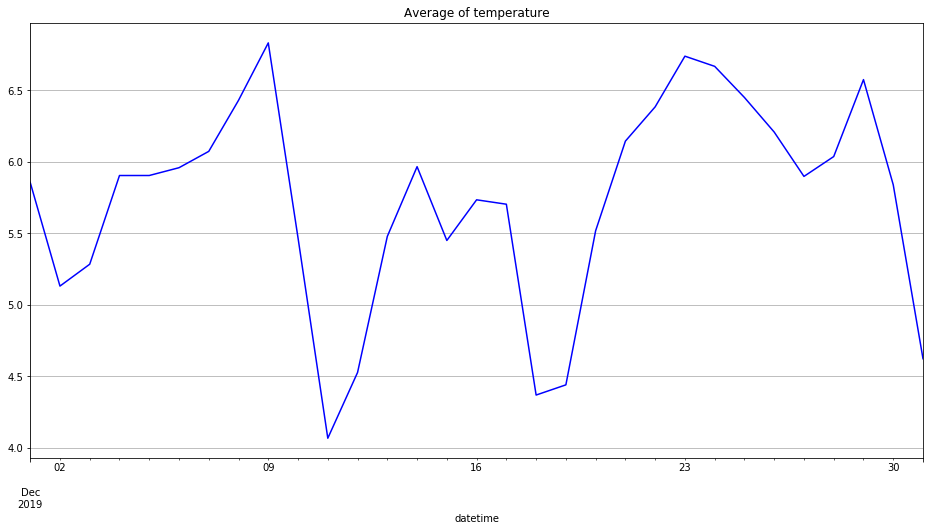

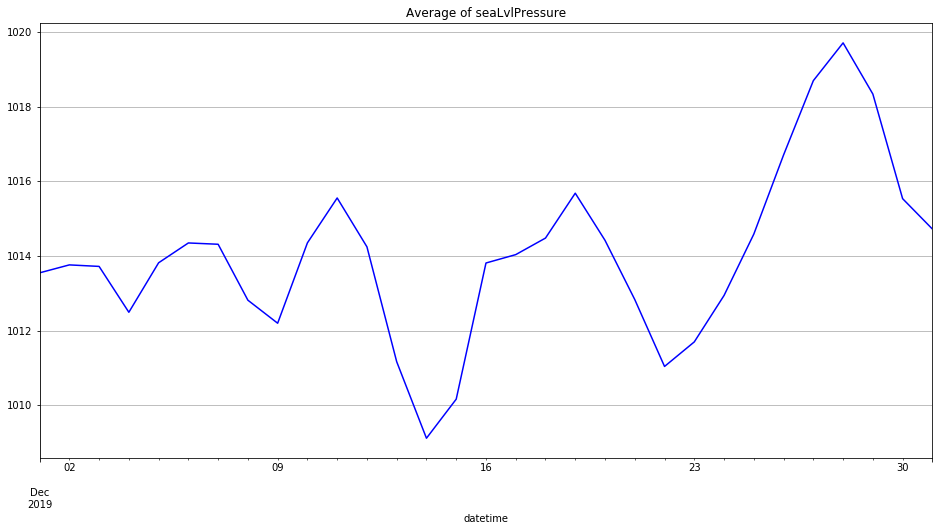

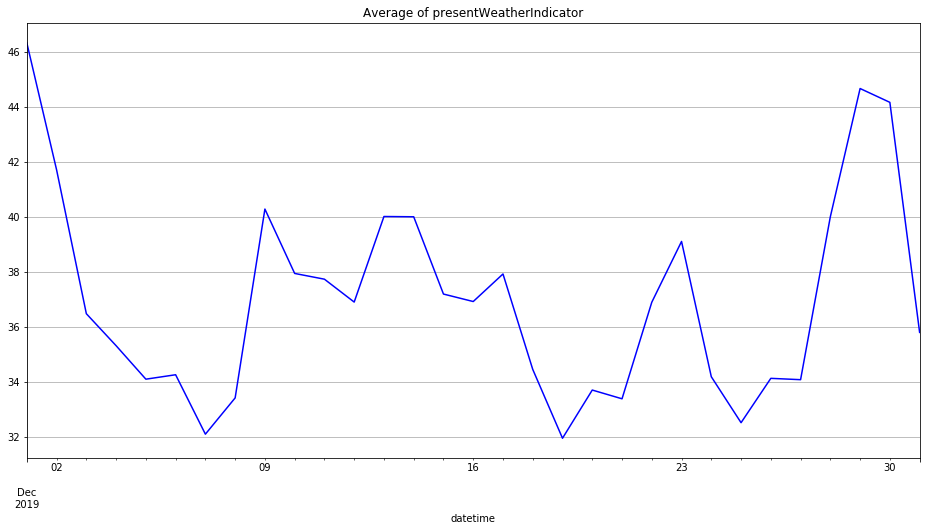

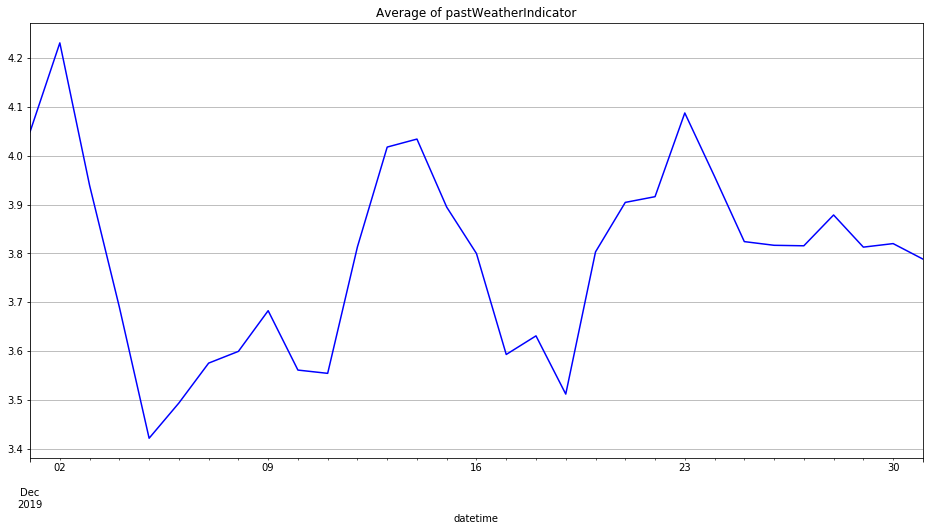

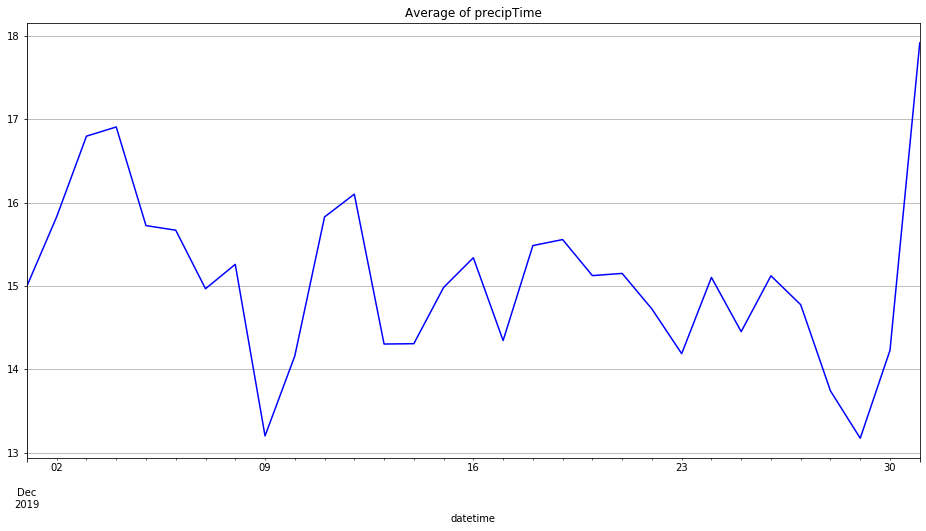

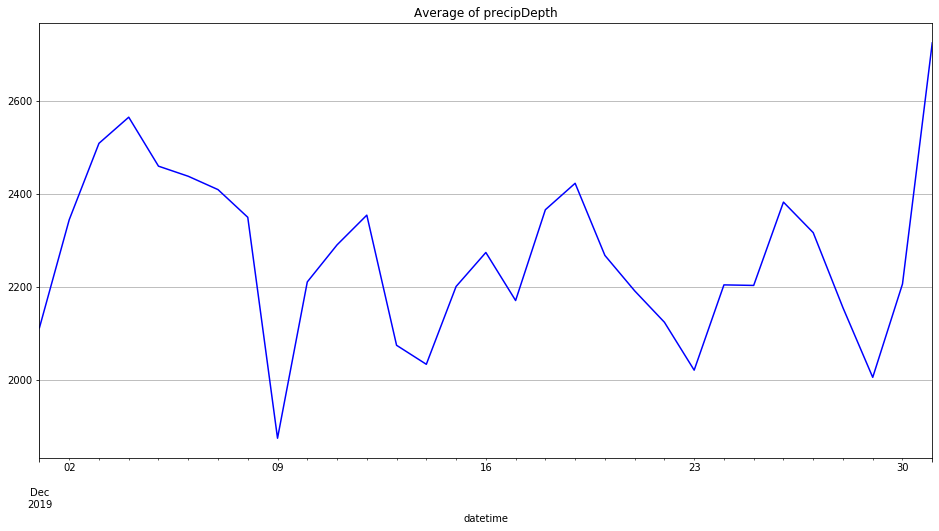

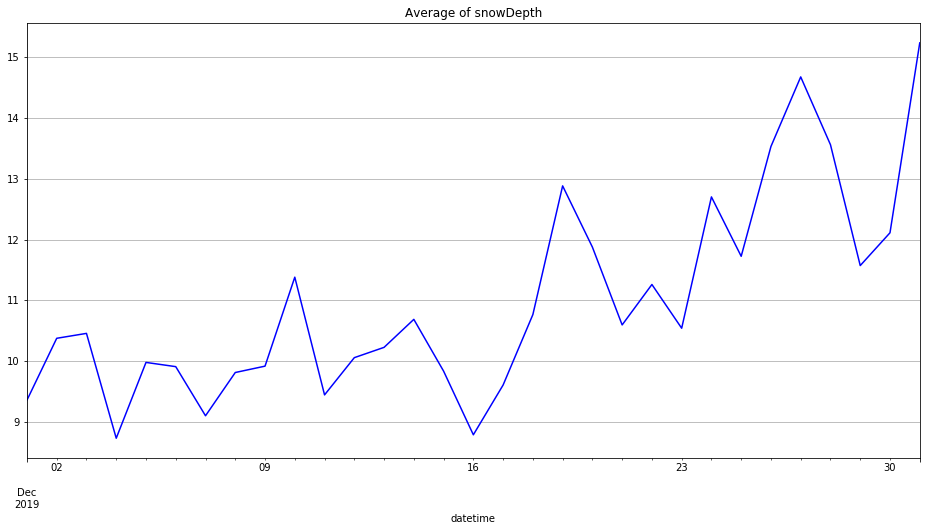

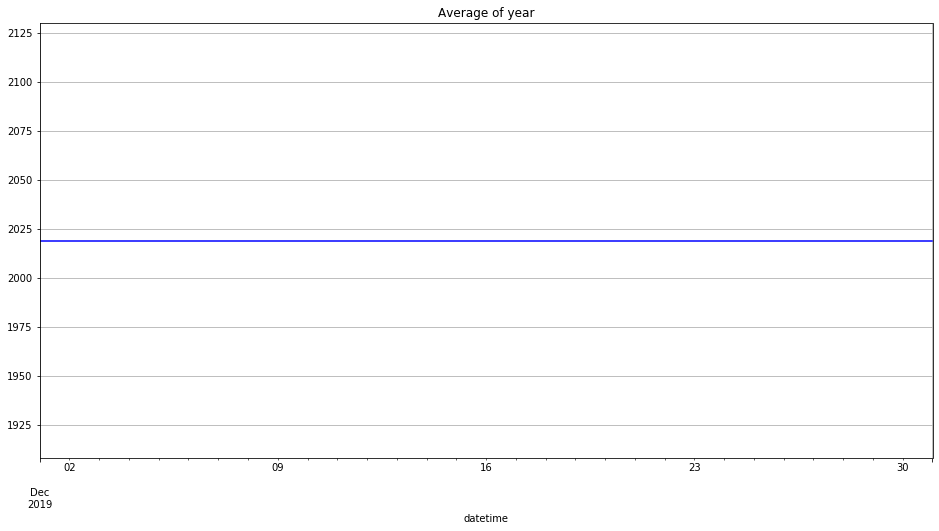

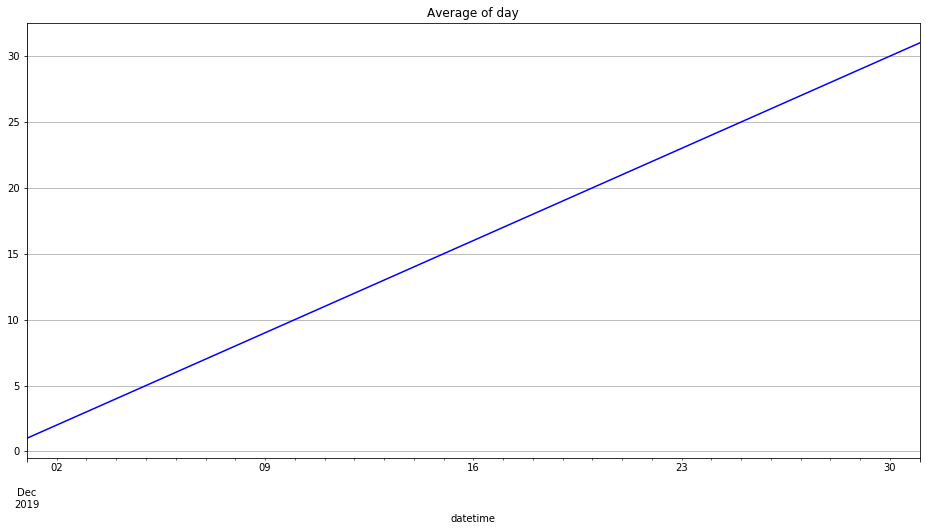

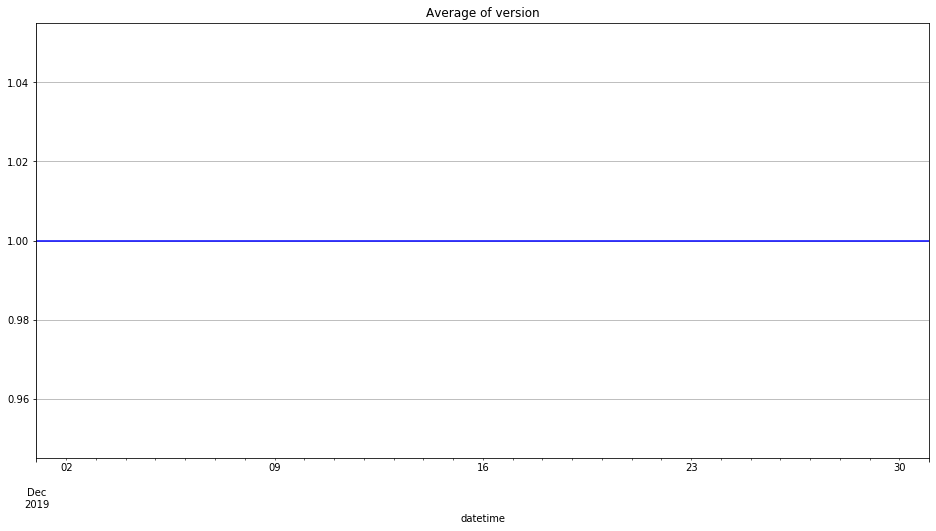

In [15]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2019, 12, 1), datetime(2019, 12, 31)])
    plt.grid()

## Scaling with Dask 'locally'

The first step in scaling up with Dask is to simply get a bigger VM. For non-GPU Compute Instances, the max is the `STANDARD_DS15_V2` with 20 cores and 140 GB of RAM. This is suitable for interactive querying and data preparation on about 1 year of the weather data, but not on the full dataset.

In [16]:
dashboard_port = 4567

c = Client(dashboard_address=f':{dashboard_port}')
print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')



<Client: 'tcp://127.0.0.1:42593' processes=6 threads=24, memory=236.64 GB>


### Take some data

Take some data. The below cells may fail on smaller VMs. 1 year works semi-reliably on a `STANDARD_DS15_V2`, although computing the means fails sometimes.

You can use the dashboard to understand what is going on with this VM being used as a "local" cluster. 

In [17]:
df = dd.read_parquet(f'{local_path}/year=201[7-8]/month=*/*.parquet', engine='pyarrow')
#df = df.repartition(npartitions=df.npartitions*10).persist()
%time df.head()

CPU times: user 382 ms, sys: 76 ms, total: 458 ms
Wall time: 7.1 s


,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,717250,99999,2017-01-01 00:00:00,48.050,-77.767,337.0,80.0,3.6,-14.2,1004.4,...,NaN,24.0,9999.0,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
1,717250,99999,2017-01-01 00:00:00,48.053,-77.783,337.0,80.0,3.6,-14.0,1004.3,...,NaN,NaN,NaN,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
2,717250,99999,2017-01-01 01:00:00,48.053,-77.783,337.0,80.0,3.1,-14.0,1004.0,...,NaN,NaN,NaN,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
3,717250,99999,2017-01-01 02:00:00,48.053,-77.783,337.0,80.0,2.6,-14.0,1003.5,...,NaN,NaN,NaN,NaN,VAL D OR,CA,717250-99999,2017,1,1.0
4,717250,99999,2017-01-01 03:00:00,48.050,-77.767,337.0,50.0,2.1,-14.2,1003.2,...,NaN,3.0,9999.0,NaN,VAL D OR,CA,717250-99999,2017,1,1.0


In [18]:
%time len(df)

CPU times: user 257 ms, sys: 36.1 ms, total: 294 ms
Wall time: 3.01 s


253228861

In [19]:
%time df.describe().compute()

CPU times: user 11.1 s, sys: 1.27 s, total: 12.4 s
Wall time: 52.5 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,2.532289e+08,2.532289e+08,2.532289e+08,2.091104e+08,2.173500e+08,2.486149e+08,9.888802e+07,2.274568e+07,8.802492e+06,6.191478e+07,6.191478e+07,2.129887e+06,2.532289e+08,2.532289e+08,253228861.0
mean,3.644910e+01,-3.599169e+01,3.785063e+02,1.663294e+02,3.401879e+00,1.235520e+01,1.014926e+03,3.138943e+01,4.320648e+00,1.573061e+01,2.288497e+03,1.479879e+01,2.017501e+03,1.567348e+01,1.0
std,2.295099e+01,7.871266e+01,6.047611e+02,1.138311e+02,2.822234e+00,1.244197e+01,9.178970e+00,2.996476e+01,3.001547e+00,3.027646e+01,4.190481e+03,2.562797e+01,4.999978e-01,8.821065e+00,0.0
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-8.220000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.017000e+03,1.000000e+00,1.0
25%,3.297300e+01,-9.532000e+01,4.200000e+01,7.600000e+01,1.500000e+00,7.000000e+00,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.017000e+03,8.000000e+00,1.0
50%,4.136700e+01,-7.113000e+01,1.870000e+02,1.900000e+02,3.100000e+00,1.600000e+01,1.017200e+03,5.100000e+01,5.000000e+00,1.000000e+00,1.000000e+00,9.000000e+00,2.018000e+03,1.600000e+01,1.0
75%,4.878400e+01,1.711800e+01,4.450000e+02,2.760000e+02,5.100000e+00,2.700000e+01,1.025300e+03,7.000000e+01,8.000000e+00,1.200000e+01,9.999000e+03,5.300000e+01,2.018000e+03,2.400000e+01,1.0
max,8.365600e+01,1.799980e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.060000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,8.150000e+02,2.018000e+03,3.100000e+01,1.0


In [20]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 2.05 s, sys: 371 ms, total: 2.42 s
Wall time: 34.6 s
Dataframe is: 121.6GB


In [21]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean().compute() # slow, prone to error 
means.head()

CPU times: user 2.85 s, sys: 440 ms, total: 3.29 s
Wall time: 30.9 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2017-01-01,36.310162,-35.597756,378.297693,165.082396,3.270154,4.466263,1015.012426,27.817712,3.802117,15.649717,2304.981184,17.756207,2017.0,1.0,1.0
2017-01-02,36.435578,-36.890386,379.923942,155.097028,3.201581,4.618758,1017.620313,28.856616,4.189032,14.275781,2084.624385,18.058893,2017.0,2.0,1.0
2017-01-03,36.487776,-36.656847,375.661634,174.496641,3.597815,3.929362,1017.465302,31.165388,4.374277,14.566183,2069.808970,18.109079,2017.0,3.0,1.0
2017-01-04,36.602347,-35.741762,379.585410,194.424011,4.192965,2.087930,1015.476203,33.907876,4.493803,15.262921,2197.908134,19.555854,2017.0,4.0,1.0
2017-01-05,36.575576,-35.401472,384.324082,181.703382,3.717242,0.117848,1018.097379,34.367265,4.672284,15.093806,2137.545564,18.874947,2017.0,5.0,1.0


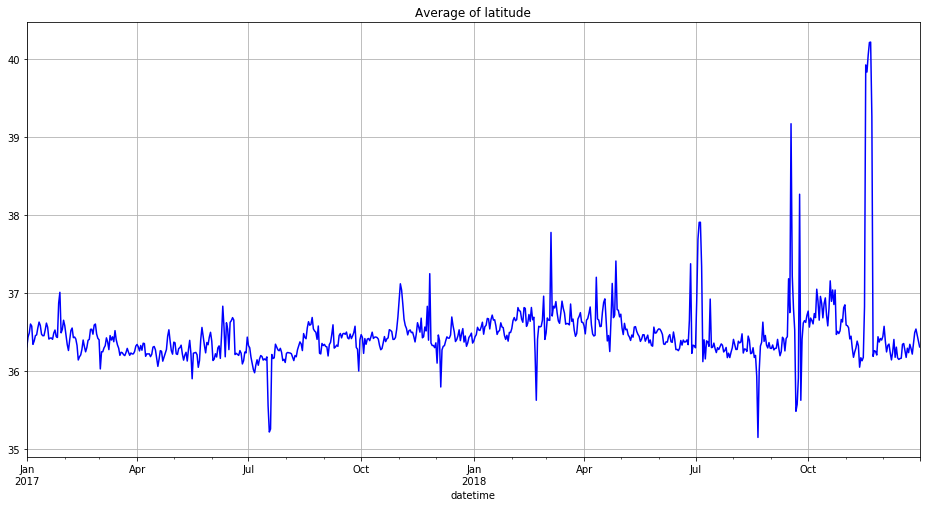

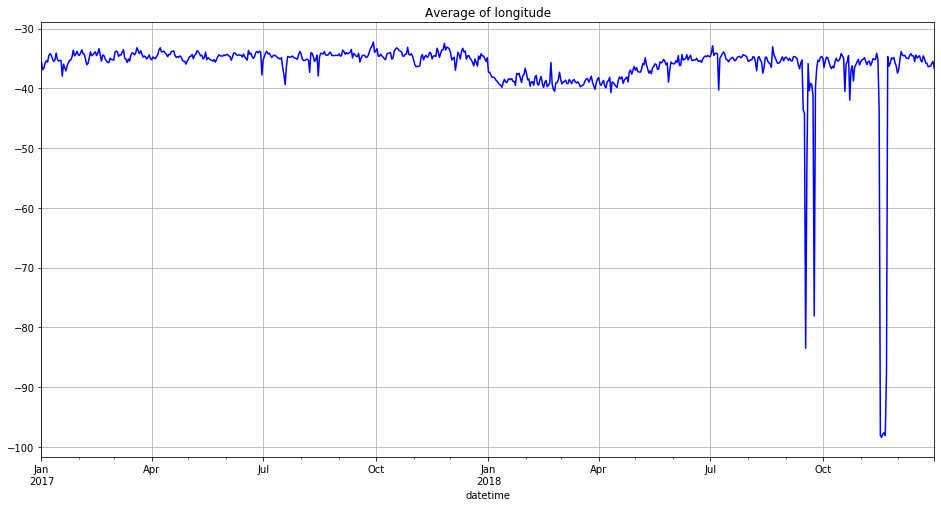

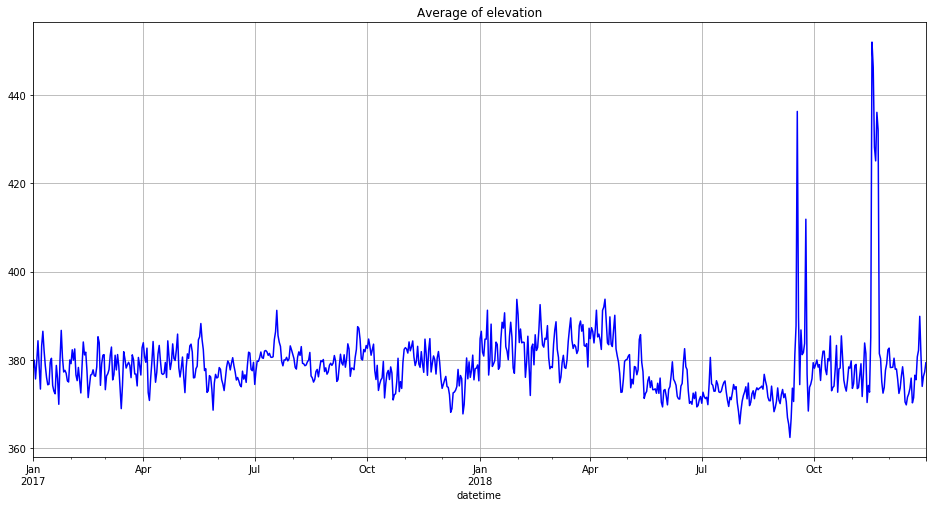

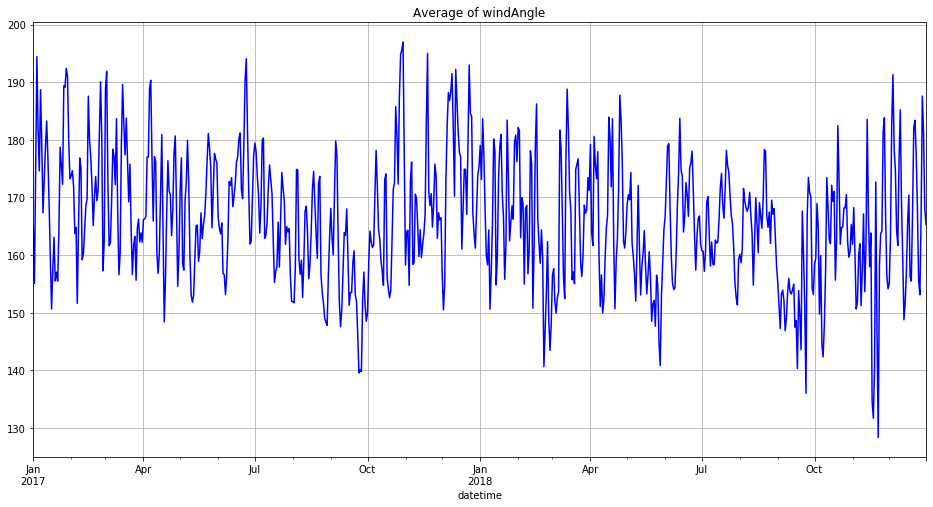

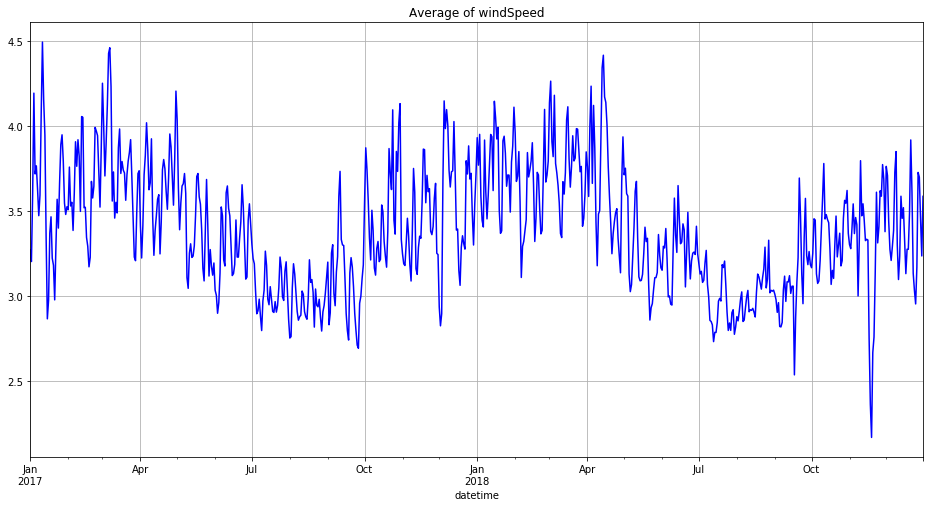

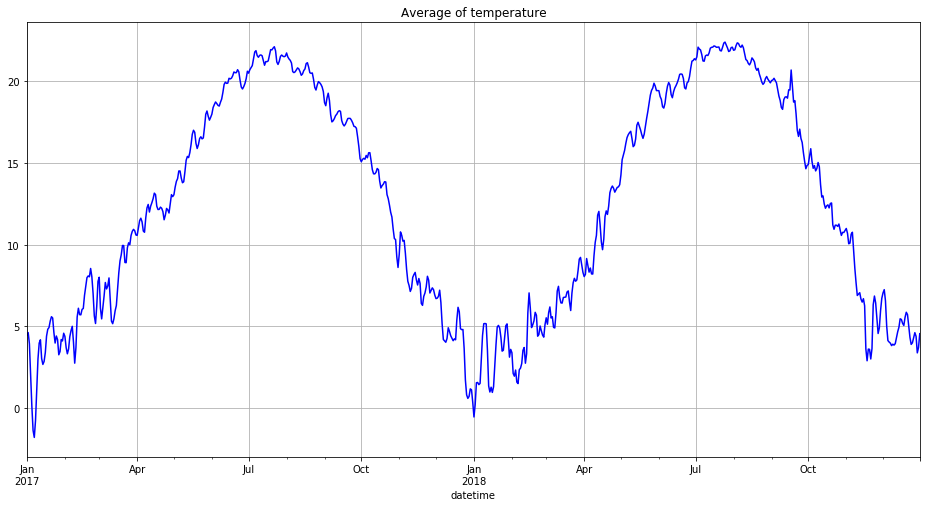

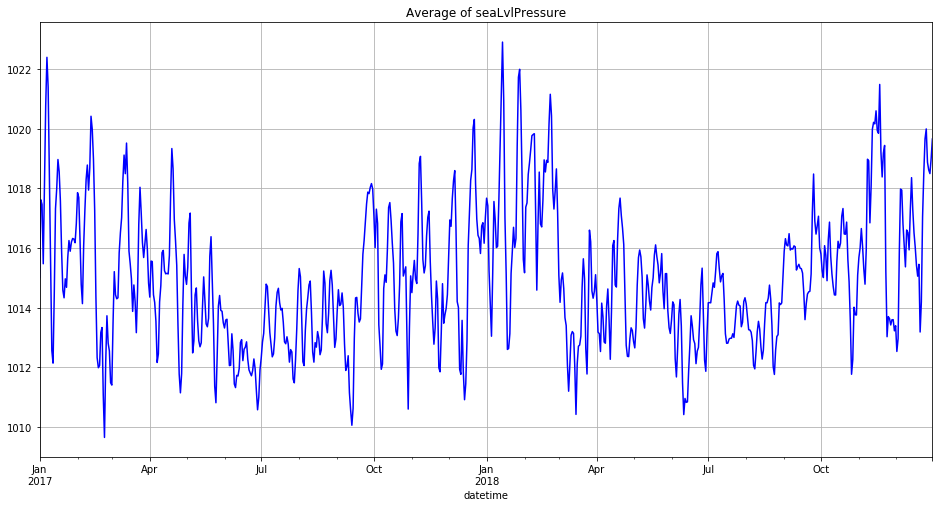

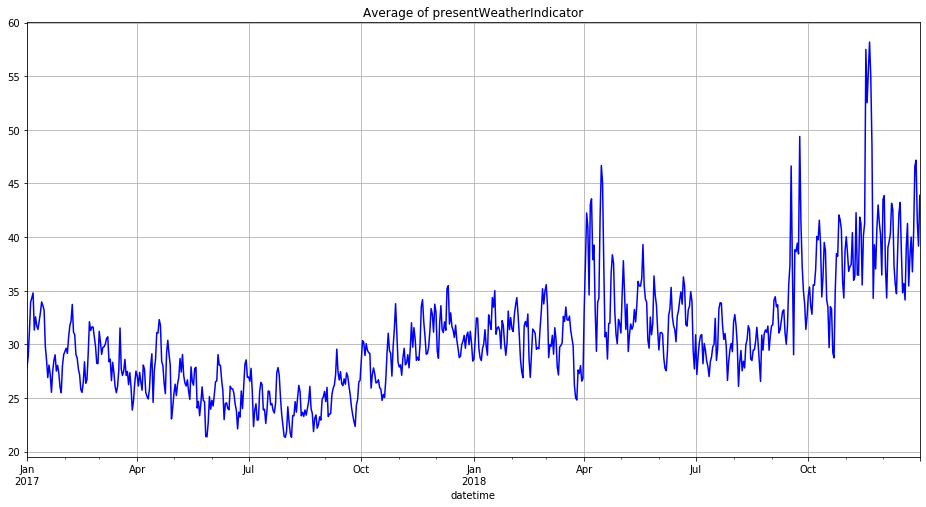

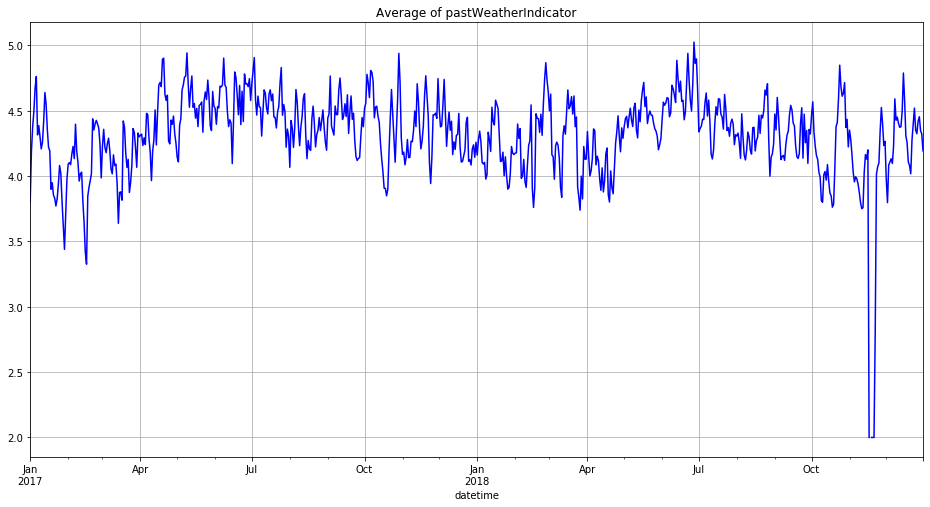

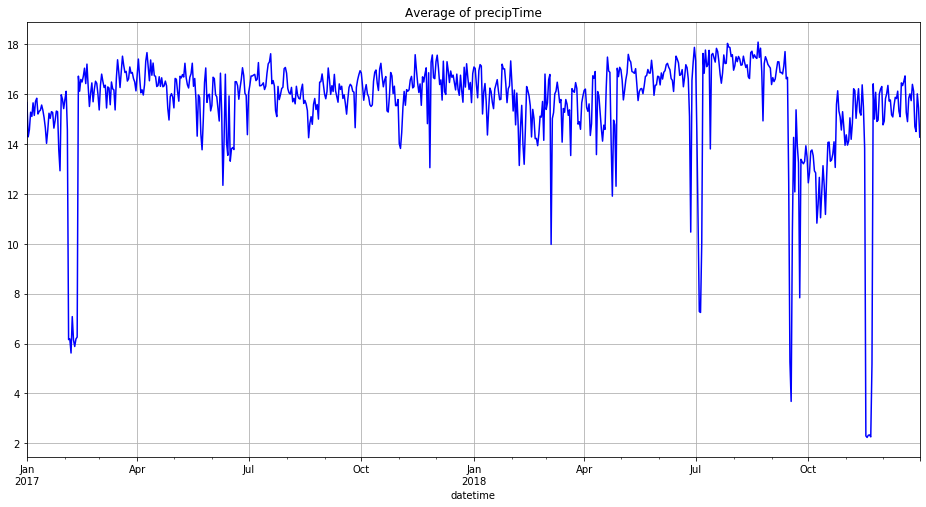

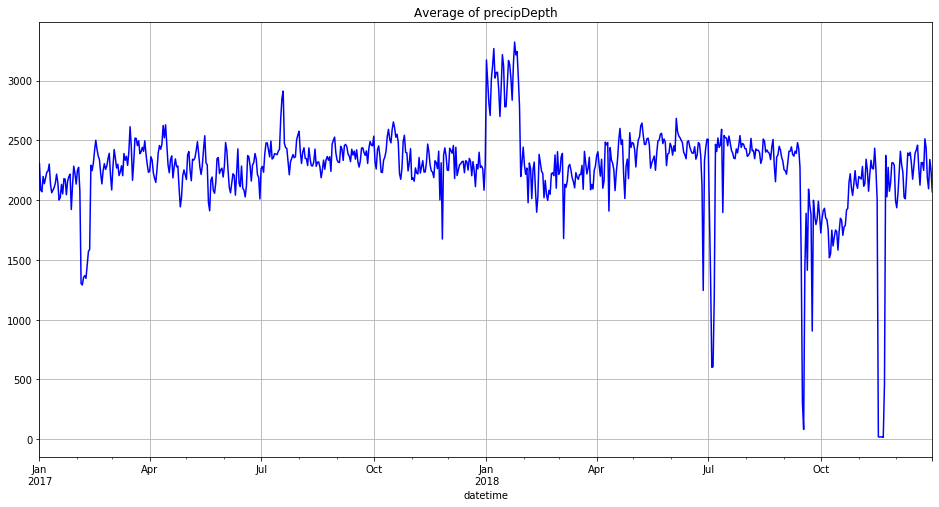

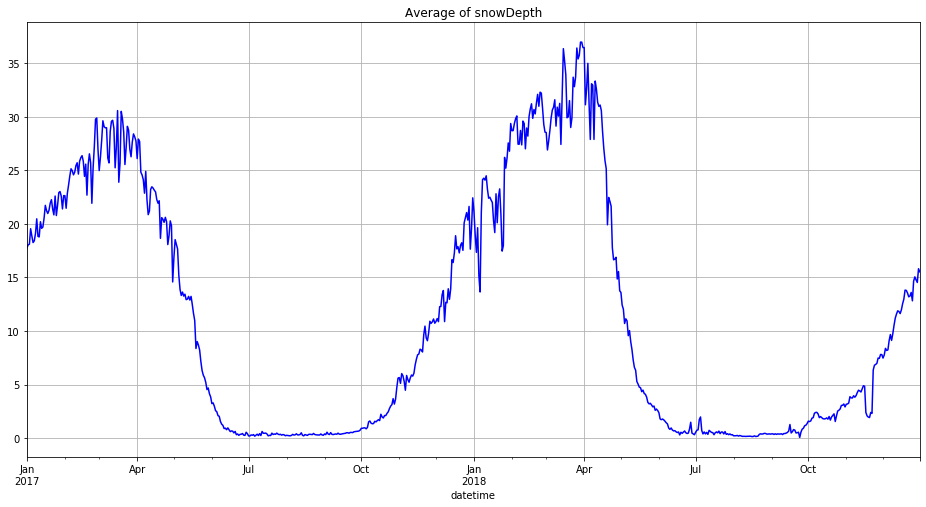

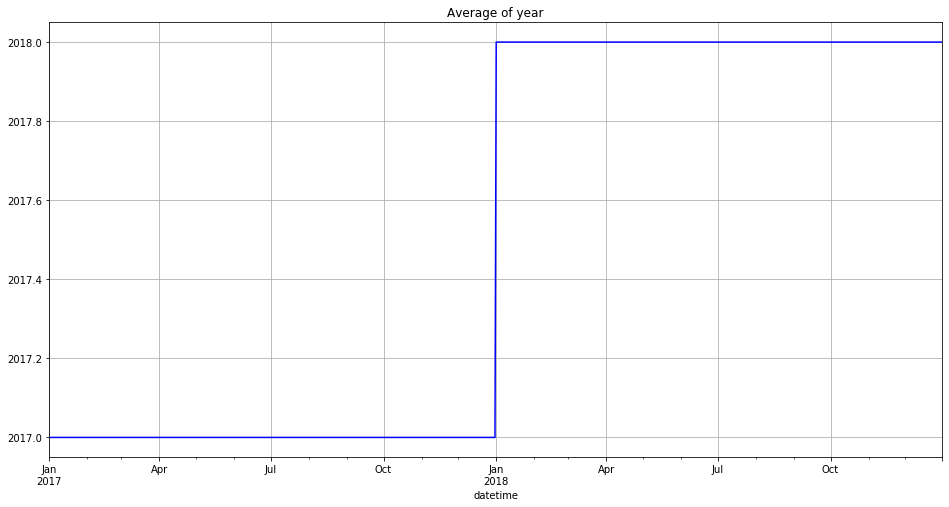

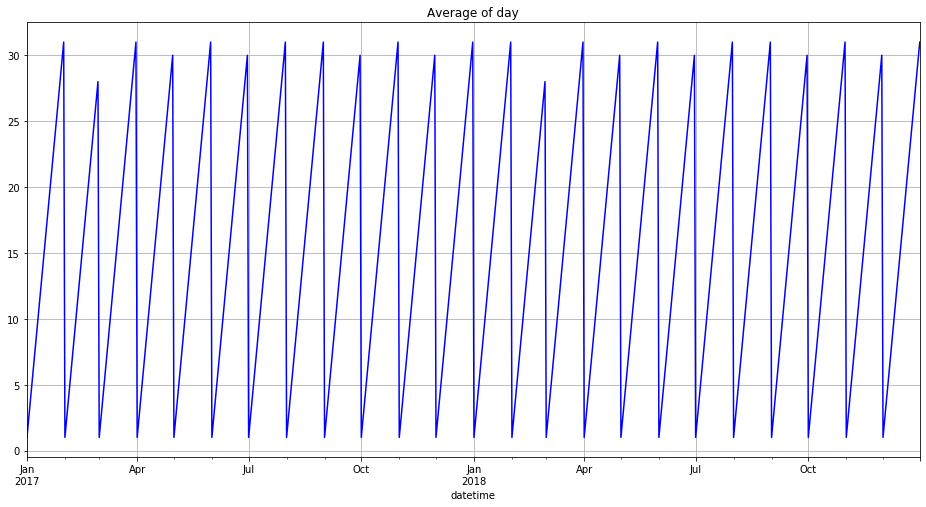

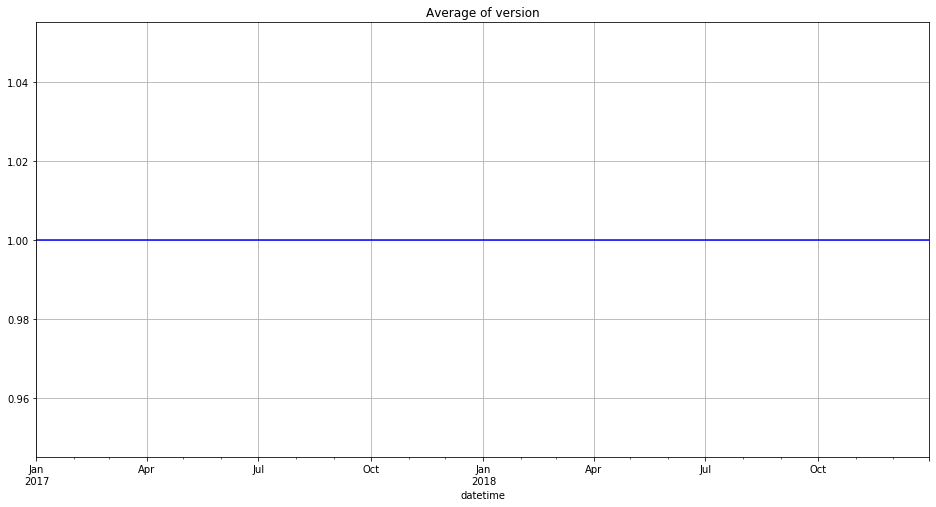

In [22]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2017, 1, 1), datetime(2018, 12, 31)])
    plt.grid()

In [23]:
c.close()

## Scale up with Dask and Azure ML

In [24]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Connect to cluster

In [25]:
# port to forward the dask dashboard to on the compute instance
# we do not use 8787 because it is already in use 
dashboard_port = 4242

print("waiting for scheduler node's ip")
while run.get_status() != 'Canceled' and 'scheduler' not in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

if run.get_status() == 'Canceled':
    print('Run was canceled')
else:
    print(f'Setting up port forwarding...')
    os.system(f'killall socat') # kill all socat processes - cleans up previous port forward setups 
    os.system(f'setsid socat tcp-listen:{dashboard_port},reuseaddr,fork tcp:{run.get_metrics()["dashboard"]} &')
    print(f'Cluster is ready to use.')

c = Client(f'tcp://{run.get_metrics()["scheduler"]}')

print(f'\n\n{c}')

c.restart()

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')

waiting for scheduler node's ip
Setting up port forwarding...
Cluster is ready to use.


<Client: 'tcp://10.1.0.56:8786' processes=50 threads=400, memory=2.95 TB>


### Take all the data

In [26]:
files = glob.glob(f'{local_path}/year=*/month=*/*.parquet', recursive=True)
files = [file.replace('/mnt/', 'abfs://') for file in files if '2019' not in file]
files[-5:]

['abfs://data/noaa/isd/year=2012/month=10/part-00002-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-55.c000.snappy.parquet',
 'abfs://data/noaa/isd/year=2012/month=8/part-00007-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-60.c000.snappy.parquet',
 'abfs://data/noaa/isd/year=2012/month=4/part-00005-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-58.c000.snappy.parquet',
 'abfs://data/noaa/isd/year=2012/month=2/part-00011-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-64.c000.snappy.parquet',
 'abfs://data/noaa/isd/year=2012/month=5/part-00003-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-56.c000.snappy.parquet']

In [27]:
df = dask.delayed(dd.read_parquet)(files, engine='pyarrow', storage_options=STORAGE_OPTIONS).compute()
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,724755,93129,2008-01-01 00:53:00,37.702,-113.097,1712.0,350.0,3.6,-8.3,1036.2,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
1,724755,93129,2008-01-01 01:53:00,37.702,-113.097,1712.0,340.0,4.1,-11.1,1037.3,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
2,724755,93129,2008-01-01 02:53:00,37.702,-113.097,1712.0,NaN,2.1,-11.7,1039.7,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
3,724755,93129,2008-01-01 03:53:00,37.702,-113.097,1712.0,70.0,1.5,-11.1,1040.3,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
4,724755,93129,2008-01-01 04:53:00,37.702,-113.097,1712.0,NaN,1.5,-13.9,1040.4,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0


In [28]:
df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False).persist() # persist and sort data by day 
#df = df.persist()
%time len(df)

CPU times: user 590 ms, sys: 55.8 ms, total: 646 ms
Wall time: 29 s


1270243333

In [29]:
%time len(df)

CPU times: user 57.3 ms, sys: 4.38 ms, total: 61.6 ms
Wall time: 293 ms


1270243333

In [30]:
%time df.describe().compute()

ERROR - Task was destroyed but it is pending!
task: <Task pending coro=<RequestHandler._execute() running at /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tornado/web.py:1699> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f9c5f7732e8>()]> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tornado/web.py:2329]>


CPU times: user 4.54 s, sys: 405 ms, total: 4.94 s
Wall time: 52 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.270243e+09,1.270243e+09,1.270243e+09,1.013709e+09,1.053004e+09,1.247780e+09,4.429675e+08,1.133391e+08,4.778603e+07,2.635686e+08,2.635686e+08,6.999535e+06,1.270243e+09,1.270243e+09,1.270243e+09
mean,3.757216e+01,-3.953360e+01,3.982165e+02,1.650804e+02,3.441704e+00,1.197150e+01,1.014653e+03,2.889832e+01,4.276644e+00,8.590938e+00,9.023999e+02,1.885553e+01,2.013246e+03,1.572223e+01,1.000000e+00
std,2.138076e+01,7.862546e+01,5.996861e+02,1.145702e+02,2.869097e+00,1.246356e+01,9.389093e+00,2.905005e+01,2.996370e+00,1.846843e+01,2.849152e+03,3.501295e+01,3.125733e+00,8.811851e+00,0.000000e+00
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-8.860000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,3.405000e+01,-9.532000e+01,5.000000e+01,8.000000e+01,2.000000e+00,8.500000e+00,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,8.000000e+00,1.000000e+00
50%,4.161600e+01,-7.116000e+01,2.090000e+02,1.900000e+02,3.600000e+00,1.610000e+01,1.017200e+03,4.500000e+01,6.000000e+00,1.000000e+00,0.000000e+00,1.600000e+01,2.015000e+03,1.600000e+01,1.000000e+00
75%,4.920000e+01,1.769700e+01,5.490000e+02,2.800000e+02,5.700000e+00,2.780000e+01,1.026000e+03,7.100000e+01,8.000000e+00,1.200000e+01,9.999000e+03,6.300000e+01,2.018000e+03,2.400000e+01,1.000000e+00
max,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.018000e+03,3.100000e+01,1.000000e+00


In [31]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 198 ms, sys: 18.6 ms, total: 217 ms
Wall time: 15.5 s
Dataframe is: 626.5GB


In [32]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean().compute()
means.head()

CPU times: user 393 ms, sys: 23.8 ms, total: 417 ms
Wall time: 18.6 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2008-01-01,37.851544,-41.404520,351.706004,176.364994,4.031225,0.791217,1021.312605,29.191647,4.171073,5.199203,47.503108,21.776100,2008.0,1.0,1.0
2008-01-02,37.774122,-40.943714,352.504602,180.436673,4.306232,-0.932920,1021.165374,32.632597,4.152460,5.355434,44.483105,22.627133,2008.0,2.0,1.0
2008-01-03,37.781321,-40.130623,352.634351,156.904648,4.358461,-0.866068,1020.247739,32.471547,4.119097,5.402424,47.639126,23.396628,2008.0,3.0,1.0
2008-01-04,37.879647,-40.516726,353.027684,149.716467,4.318913,1.212171,1017.653427,30.277898,3.897811,5.524803,39.277930,22.328746,2008.0,4.0,1.0
2008-01-05,37.956239,-41.565558,358.450412,161.096456,4.328847,3.918379,1013.838332,30.640481,4.154117,5.342658,39.990708,23.943632,2008.0,5.0,1.0


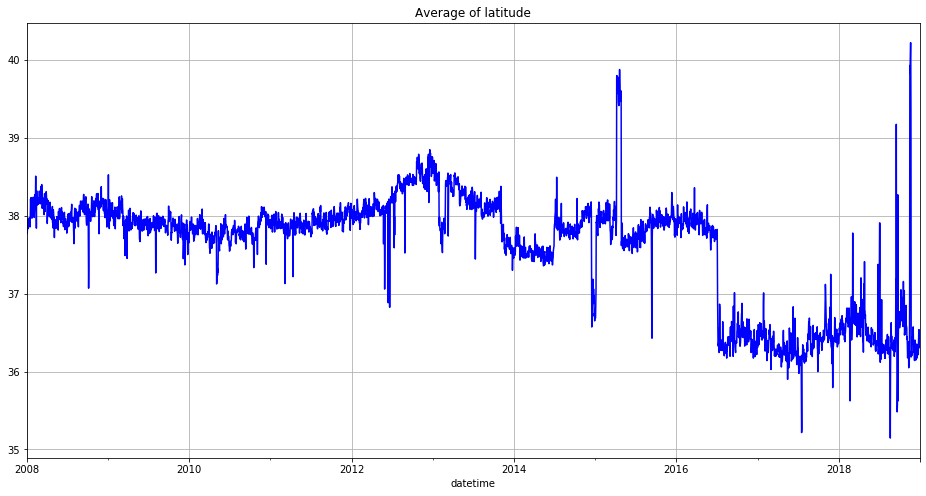

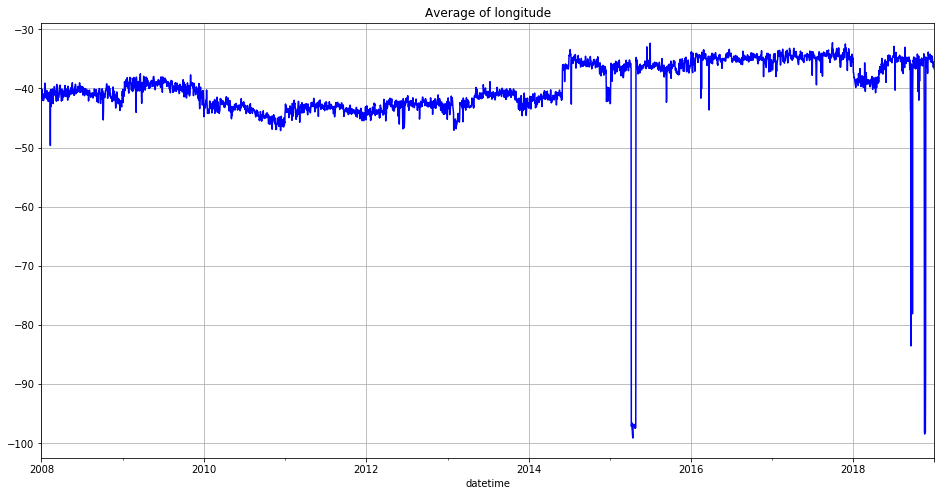

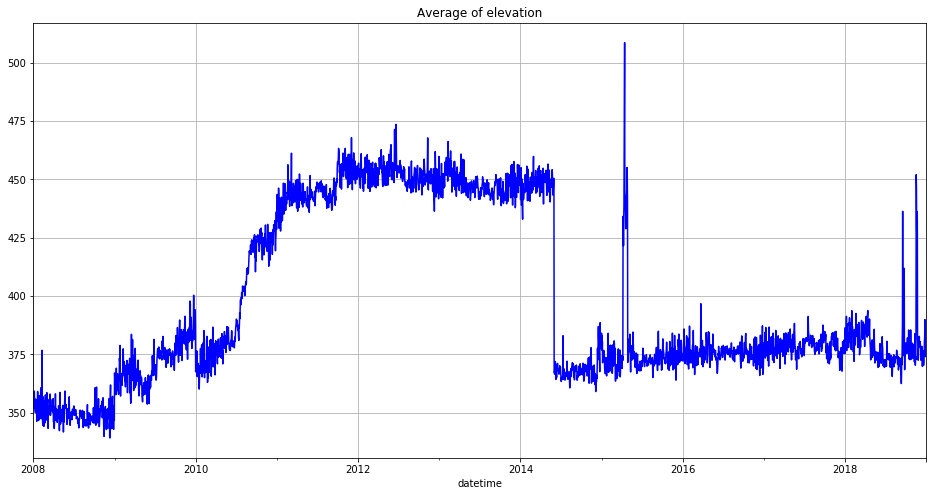

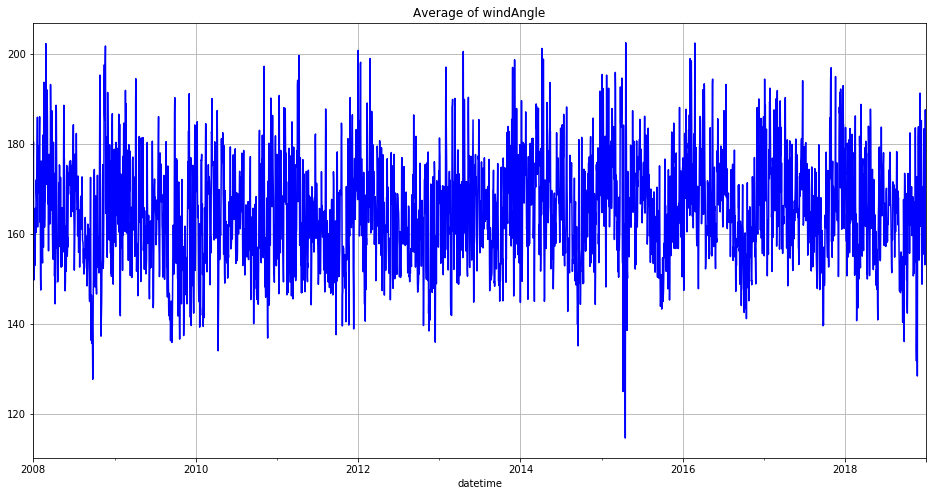

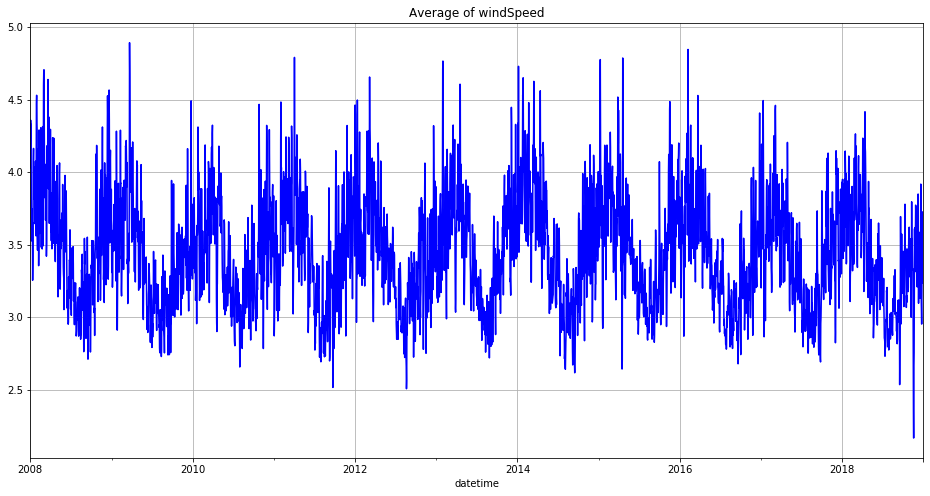

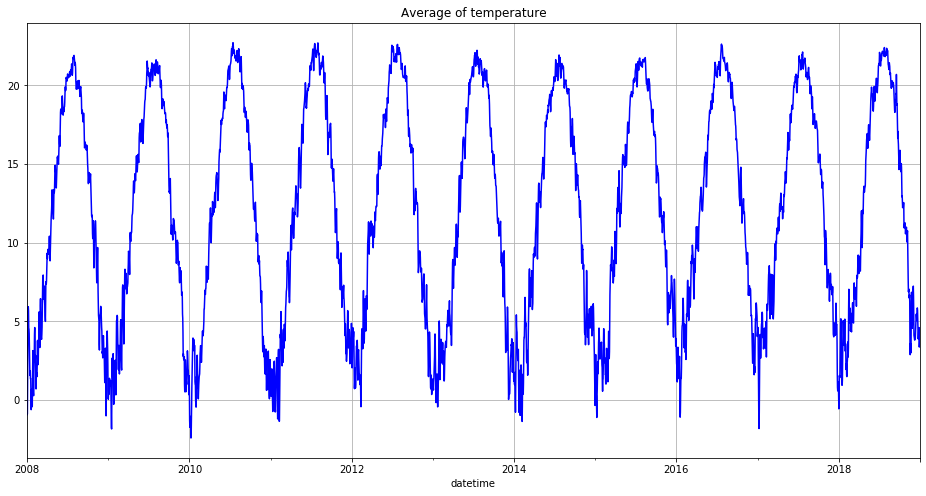

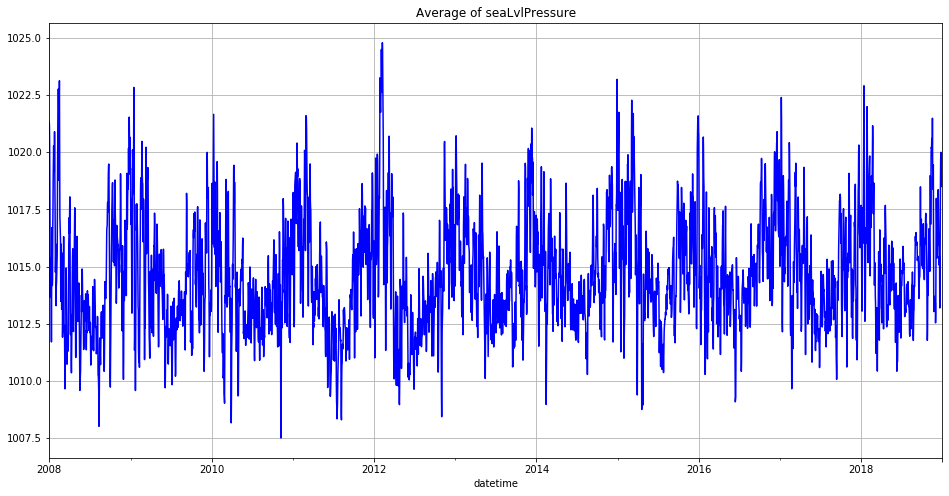

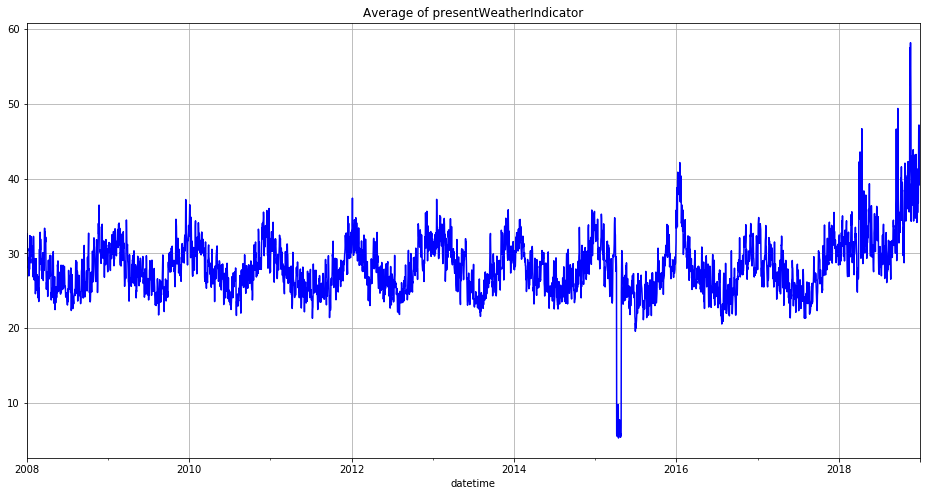

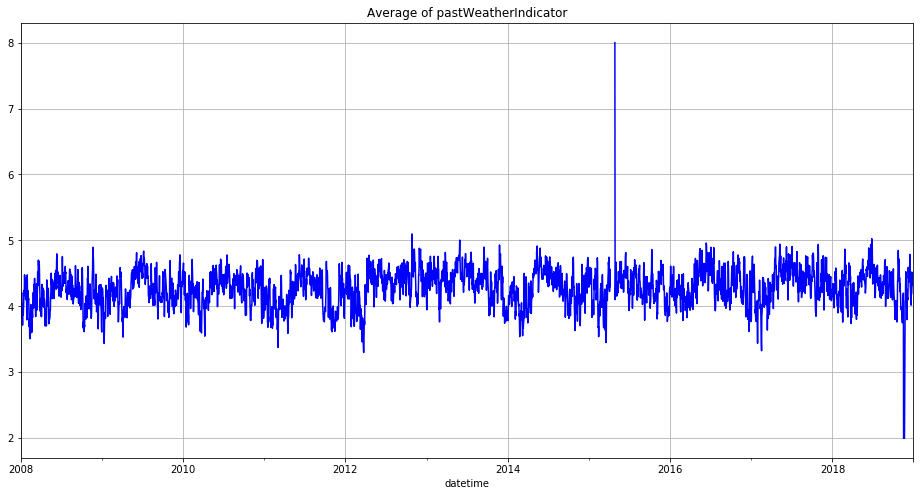

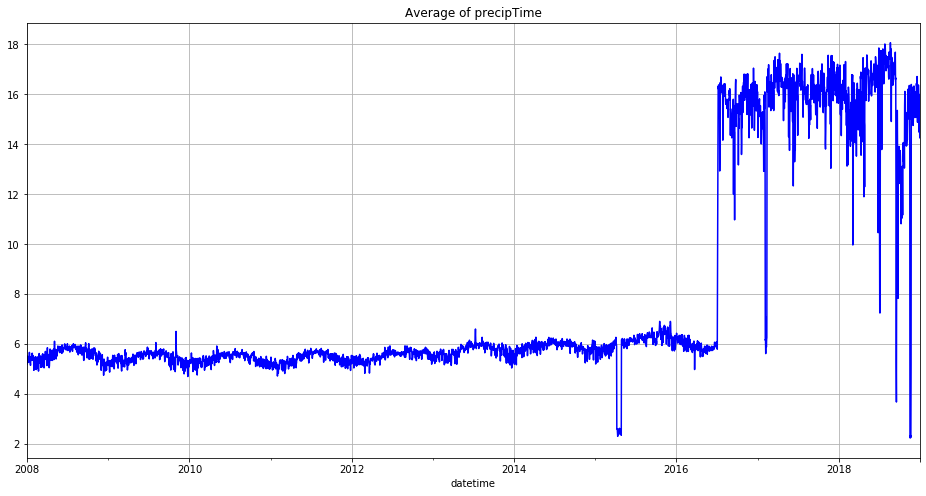

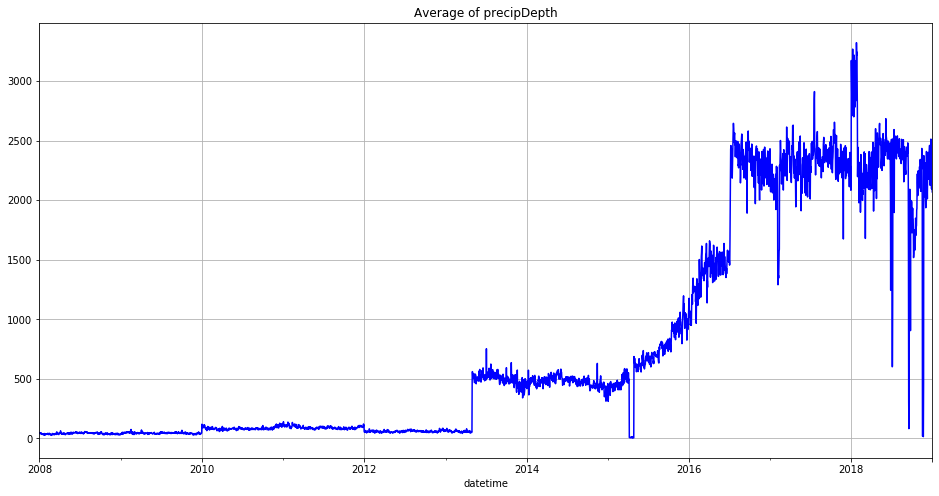

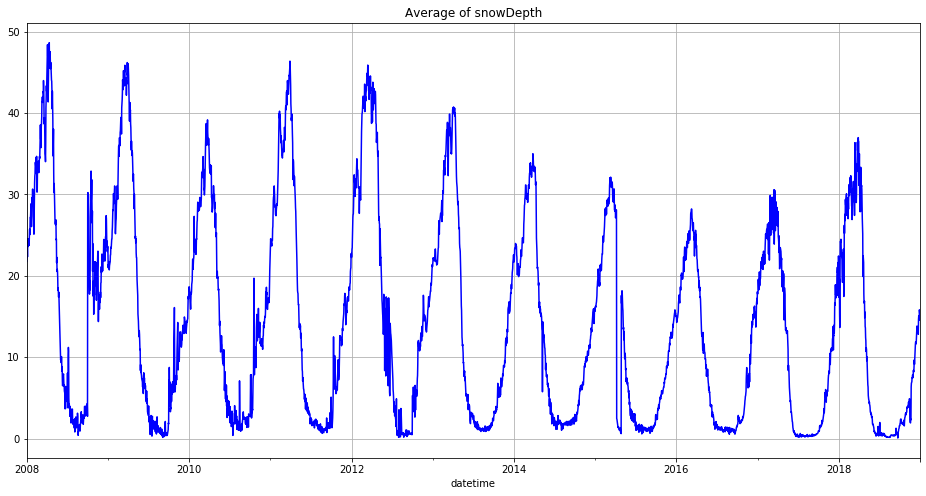

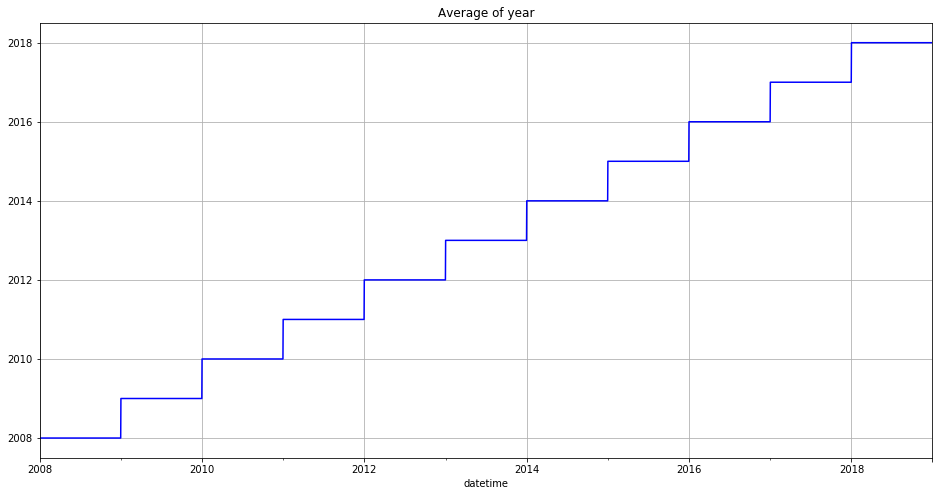

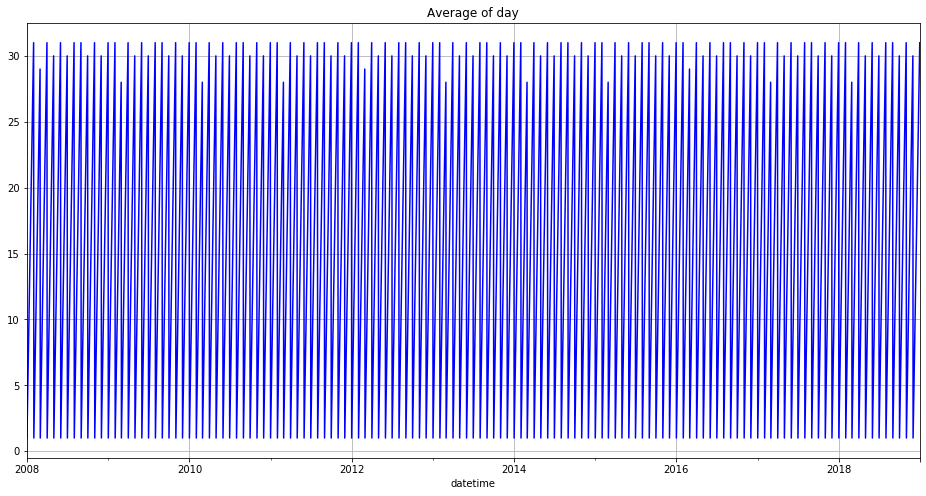

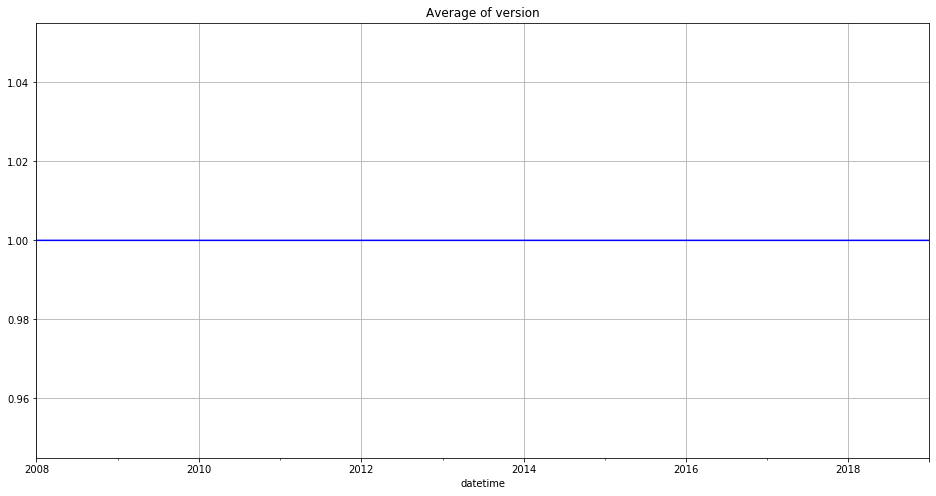

In [35]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime(2018, 12, 31)])
    plt.grid()
    
    # optionally, log the image to the run
    run.log_image(f'mean_{col}', plot=plt)

In [36]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask2020,dask2020_1578182001_6cbfa595,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


## Prepare data

In [37]:
## insert any Pandas-like Dask data prep code 
df['temperature'] = df['temperature']*(9/5)+32       # 'Merica

## Write data

**Important:** write back to ADLS gen 2.

In [39]:
%time df = dask.delayed(df.to_parquet)(f'abfs://data/noaa/isd_out.parquet', compression='lz4', storage_options=STORAGE_OPTIONS).compute()

CPU times: user 1.27 s, sys: 116 ms, total: 1.39 s
Wall time: 1min 9s


## End the run

Cluster will return to 0 nodes

In [40]:
run.cancel()